# Correcting Imbalance with Sampling Techniques and Logistic Modelling

In this notebook, we apply upsampling and downsampling techniques to rectify the imbalance in our binary target variable, churn, where we have much more data on no churn than we do on churn. Afterwards, we fit a base logistic model to our imbalanced dataset to have a baseline score unto which to compare the other models to. Then we fit logistic models to the upsampled and downsampled datasets and analyze if there is any increase in model performance on the validation. Finally, we use a pipeline and grid search to optimize the hyperparameter C for each logistic model. We then apply the same steps to the other data set from which we did feature selection on in the previous notebook to see if removing features that introduced multicollinearity has an effect on our model performance.

---

## Table of Contents

## Train-Test Split on Clean Dataset with All Features

## Sampling Techniques

### Upsampling:
### Upsampled Logistic Model with 10% Sampling Rate
- Hard Predictions Classification Report and Confusion Matrix
- ROC curve and AUC score

### Upsampled Logistic Model with 20% Sampling Rate
- Hard Predictions Classification Report and Confusion Matrix
- ROC curve and AUC score

### Downsampling:
### Downsampled Logistic Model with 10% Sampling Rate
- Hard Predictions Classification Report and Confusion Matrix
- ROC curve and AUC score

### Downsampled Logistic Model with 20% Sampling Rate
- Hard Predictions Classification Report and Confusion Matrix
- ROC curve and AUC score

## Pipelines and Hyperparameter Optimization on Data with All Features

### Base Scaled and Optimized Logistic Model on Data with All Features

### Upsampled Scaled and Optimized Logistic Model with 20% sampling rate
- Hard Predictions Classification Report and Confusion Matrix
- ROC curve and AUC score

### Downsampled Scaled and Optimized Logistic Model with 20% sampling rate
- Hard Predictions Classification Report and Confusion Matrix
- ROC curve and AUC score


## Train-Test Split on Clean Dataset with  Feature Selection



## Sampling Techniques, Pipelines, and Hyperparameter Optimization on Dataset with  Feature Selection

#### Upsampled Scaled and Optimized Logistic Model with 20% sampling rate on Feature Selected Data
- Hard Predictions Classification Report and Confusion Matrix
- ROC curve and AUC score

#### Downsampled Scaled and Optimized Logistic Model with 20% sampling rate on Feature Selected Data
- Hard Predictions Classification Report and Confusion Matrix
- ROC curve and AUC score

## Summary:
### Feature Coefficient Importance and Odds Ratio Visualizations
- Data with All Features
- Data with Feature Seleciton

### Logistic Model Table Summary


---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import plot_roc_curve

from sklearn.preprocessing import StandardScaler
from tempfile import mkdtemp
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### Train-Test Split on Clean Dataset with All Features

We begin by reading in our pickled clean dataset from the previous notebook on Feature Engineering. This dataset contains all features. 

In [93]:
data = pd.read_pickle('clean_data.pkl')

In [3]:
data.head()

,Reg_3,Reg_4,Reg_7,Reg_9,City_1,pay_38,pay_39,pay_40,pay_41,msno,...,trans_weekday,trans_month,trans_year,mem_exp_day,mem_exp_weekday,mem_exp_month,mem_exp_year,user__weekday,user__month,user__year
0,1,0,0,0,0,1,0,0,0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,...,1,2,2017,30,3,3,2017,6,3,2017
1,1,0,0,0,0,0,0,0,0,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,...,5,3,2017,11,1,4,2017,0,3,2017
2,1,0,0,0,0,0,0,0,0,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,...,1,3,2017,15,3,6,2017,3,3,2017
4,0,0,1,0,0,0,0,0,1,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,...,3,3,2017,18,0,9,2017,5,3,2017
5,1,0,0,0,0,0,0,1,0,ibIHVYBqxGwrSExE63/omeDD99M5vYB3CN2HzkEY+eM=,...,3,3,2017,14,1,3,2017,2,3,2017


In [4]:
data.shape

(754532, 38)

Since the given test set had only 0 churn rate, we need to split our clean data set into train and test and then work on fixing the imbalance in the train set with upsampling and downsampling techniques. We will also need to split again into train and validation so as to not introduce bias on our test, which we save until the end for scoring our final validation prediction to the test.

In [5]:
X = data.drop(['is_churn', 'msno'], axis=1)
y = data['is_churn']

In [6]:
X_remainder, X_test, y_remainder, y_test = \
    train_test_split(X,y, test_size=0.2, random_state=1)

In [7]:
# Splitting the remainder in two chunks
X_train, X_validation, y_train, y_validation = \
    train_test_split(X_remainder, y_remainder, test_size = 0.3,
                     random_state=1, stratify= y_remainder)

Our final proportions end up being 
* Test Set: *0.2*
* Validation Set:  0.8 * 0.3 = *0.24*
* Training Set: 0.8 * 0.7 = *0.56*

We can check the sizes of each chunk. Originally, in the data set we have 754,532 data points. When rounded, we should expect

* Test Set: 0.2 * 754,532 = 150,906
* Validation Set: 0.24 * 754,532 = 181,088
* Training Set: 0.56 * 754,532 = 422,538

In [8]:
#sanity check
X_train.shape, X_validation.shape, y_train.shape, y_validation.shape

((422537, 36), (181088, 36), (422537,), (181088,))

In [9]:
# Preserving unsampled split data (remainder and test)
X_remainder.to_pickle('X_remainder.pkl')
y_remainder.to_pickle("y_remainder.pkl")

X_test.to_pickle("X_test.pkl")
y_test.to_pickle("y_test.pkl")

In [10]:
# Preserving unsampled split data (train and validation)
X_train.to_pickle('X_train.pkl')
y_train.to_pickle("y_train.pkl")

X_validation.to_pickle("X_validation.pkl")
y_validation.to_pickle("y_validation.pkl")

---

## Sampling Techniques

### Upsampling

To potentially improve our model, we can "upsample" the *minority* class. This entails us resampling the observations that belong to the underrepresented class so that our training data consists of equal proportions of each class.

In [15]:
print('Number of class 1 examples before:', X_train[y_train == 1].shape[0])

# upsample is_churn == 1
X_upsampled, y_upsampled = resample(X_train[y_train == 1], 
                                    y_train[y_train == 1], 
                                    replace=True, 
                                    n_samples=X_train[y_train == 0].shape[0], 
                                    random_state=1)

print('Number of class 1 examples after:', X_upsampled.shape[0])
print('Upsampled Sampling Rate:', X_train[y_train == 1].shape[0]/X_upsampled.shape[0])


# Combine upsample with original data
X_train_up_bal = np.vstack((X_train[y_train == 0], X_upsampled))
y_train_up_bal = np.hstack((y_train[y_train == 0], y_upsampled))

Number of class 1 examples before: 37934
Number of class 1 examples after: 384603
Upsampled Sampling Rate: 0.09863157593674517


In [13]:
X_train_up_bal.shape, y_train_up_bal.shape

((769206, 36), (769206,))

### Upsampled Logistic Model with 10% Sampling Rate

/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Confusion matrices: 



/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


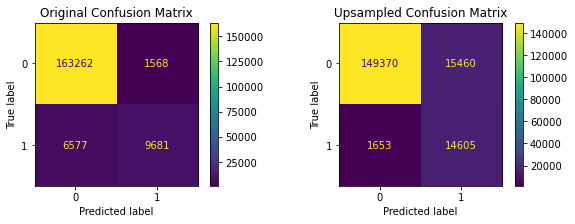


Original data classification report: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98    164830
           1       0.86      0.60      0.70     16258

    accuracy                           0.96    181088
   macro avg       0.91      0.79      0.84    181088
weighted avg       0.95      0.96      0.95    181088


Upsampled data classification report: 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95    164830
           1       0.49      0.90      0.63     16258

    accuracy                           0.91    181088
   macro avg       0.74      0.90      0.79    181088
weighted avg       0.94      0.91      0.92    181088



In [26]:
#####################
### MODEL FITTING ###
#####################

# on the original data
churn_logit = LogisticRegression(solver='lbfgs', random_state=1, max_iter=10000)
churn_logit.fit(X_train, y_train)

# evaluate on the original test set
y_pred = churn_logit.predict(X_validation)

# classification report
report_initial = classification_report(y_validation, y_pred)


# on the upsampled data
churn_logit_up_bal = LogisticRegression(solver='lbfgs', random_state=1, max_iter=10000)
churn_logit_up_bal.fit(X_train_up_bal, y_train_up_bal)

# evaluate on the original test set - NO UPSAMPLING
y_pred_up_bal = churn_logit_up_bal.predict(X_validation) 

# classification report
report_upsampled = classification_report(y_validation, y_pred_up_bal)


#####################
### PRINT RESULTS ###
#####################

print_line = "\n=======================================================\n"

# Confusion matrices
print("Confusion matrices:", print_line)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Model on the original data
plot_confusion_matrix(churn_logit, X_validation, y_validation, ax=axes[0])
axes[0].set_title('Original Confusion Matrix')

# Model on the upsampled data
plot_confusion_matrix(churn_logit_up_bal, X_validation, y_validation, ax=axes[1])
axes[1].set_title('Upsampled Confusion Matrix')

plt.show()

# Classification Reports
print("\nOriginal data classification report:", print_line, report_initial)
print("\nUpsampled data classification report:", print_line, report_upsampled)

Our upsampled logistic model with a sampling rate of 10%, on the data having all features, has not improved model performance on the validation when compared to the original logistic model on the imbalanced data (no sampling). The f1-score has gone down by 7% (from 70% to 63%) and precision has also dropped by 37% (from 86% to 49%). The only metric which has improved is recall which has gone up by 30% (from 60% to 90%).

---

### Upsampled Logistic Model with 20% Sampling Rate

Let'see if we can improve our upsampled model performance on the validation set by increasing the sampling rate by 20%. 

In [16]:
X_upsampled_20, y_upsampled_20 = resample(X_train[y_train == 1], 
                                    y_train[y_train == 1], 
                                    replace=True, 
                                    n_samples= round((X_train[y_train == 1].shape[0])/0.2), 
                                    random_state=1)

print('Number of class 1 examples before:', X_train[y_train == 1].shape[0])
print('Number of class 1 examples after:', X_upsampled_20.shape[0])
print('Upsampled Sampling Rate:', X_train[y_train == 1].shape[0]/X_upsampled_20.shape[0])

# Combine upsample with original data
X_train_up_bal_20 = np.vstack((X_train[y_train == 0], X_upsampled_20))
y_train_up_bal_20 = np.hstack((y_train[y_train == 0], y_upsampled_20))

Number of class 1 examples before: 37934
Number of class 1 examples after: 189670
Upsampled Sampling Rate: 0.2


In [17]:
# Storing 20% unsampled split data using magic command %store
# Cannot use pandas pickling on numpy array
%store X_train_up_bal_20
%store y_train_up_bal_20

Stored 'X_train_up_bal_20' (ndarray)
Stored 'y_train_up_bal_20' (ndarray)


/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Confusion matrices: 



/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


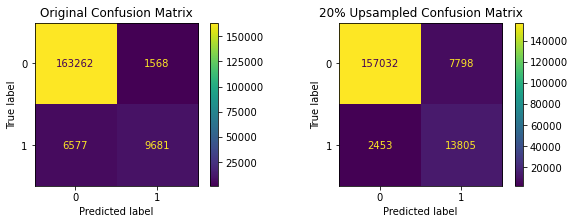


Original data classification report: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98    164830
           1       0.86      0.60      0.70     16258

    accuracy                           0.96    181088
   macro avg       0.91      0.79      0.84    181088
weighted avg       0.95      0.96      0.95    181088


20% Upsampled data classification report: 
               precision    recall  f1-score   support

           0       0.98      0.95      0.97    164830
           1       0.64      0.85      0.73     16258

    accuracy                           0.94    181088
   macro avg       0.81      0.90      0.85    181088
weighted avg       0.95      0.94      0.95    181088



In [51]:
#####################
### MODEL FITTING ###
#####################

# on the upsampled data having 20% upsampling rate
churn_logit_up_bal_20 = LogisticRegression(solver='lbfgs', random_state=1, max_iter=10000)
churn_logit_up_bal_20.fit(X_train_up_bal_20, y_train_up_bal_20)

# evaluate on the original test set - NO UPSAMPLING
y_pred_up_bal_20 = churn_logit_up_bal_20.predict(X_validation) 

# classification report
report_upsampled_20 = classification_report(y_validation, y_pred_up_bal_20)


#####################
### PRINT RESULTS ###
#####################

print_line = "\n=======================================================\n"

# Confusion matrices
print("Confusion matrices:", print_line)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Model on the original data
plot_confusion_matrix(churn_logit, X_validation, y_validation, ax=axes[0])
axes[0].set_title('Original Confusion Matrix')

# Model on the 20% upsampled data
plot_confusion_matrix(churn_logit_up_bal_20, X_validation, y_validation, ax=axes[1])
axes[1].set_title('20% Upsampled Confusion Matrix')

plt.show()

# Classification Reports
print("\nOriginal data classification report:", print_line, report_initial)
print("\n20% Upsampled data classification report:", print_line, report_upsampled_20)

Our upsampled logistic model with a sampling rate of 20%, on the data having all features, has improved model performance on the validation when compared to the original logistic model on the imbalanced data (no sampling). The f1-score has gone up by 3% (from 70% to 73%) and recall has gone up by 25% (from 60% to 85%). However, precision has dropped by 22% (from 86% to 64%). Compared to the 10% upsampled model, there is also improvement especially in the f1-score which has gone up by 10% (from 63% to 73%). Precision has also gone up by 15% (from 49% to 64%) but recall has decreased by 5% (from 90% to 85%). Our next way to improve this will be to apply the same steps but downsample instead. As well, we will optimize and scale in the next section which should  also drive up performance.  

---

## Downsampling

### Downsampled Logistic Model with 10% Sampling Rate
We can also "downsample" the *majority* class to have a smaller number of observations to balance out the classes.

In [54]:
# Downsample
print('Number of class 0 examples before:', X_train[y_train == 0].shape[0])

X_downsampled, y_downsampled = resample(X_train[y_train == 0], 
                                        y_train[y_train == 0], 
                                        replace=True, 
                                        n_samples=X_train[y_train == 1].shape[0], 
                                        random_state=1)

print('Number of class 0 examples after:', X_downsampled.shape[0])

print('Ratio of class 0 after to before:', X_downsampled.shape[0]/X_train[y_train == 0].shape[0])
# Combine downsample with original data
X_train_down_bal = np.vstack((X_train[y_train == 1], X_downsampled))
y_train_down_bal = np.hstack((y_train[y_train == 1], y_downsampled))

Number of class 0 examples before: 384603
Number of class 0 examples after: 37934
Ratio of class 0 after to before: 0.09863157593674517


/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Confusion matrices: 



/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


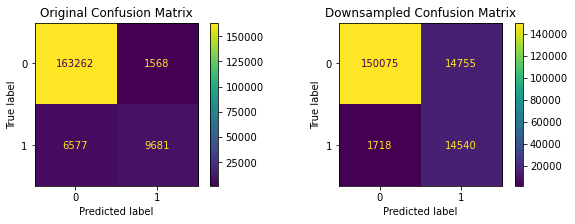


Original data classification report: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98    164830
           1       0.86      0.60      0.70     16258

    accuracy                           0.96    181088
   macro avg       0.91      0.79      0.84    181088
weighted avg       0.95      0.96      0.95    181088


Downsampled data classification report: 
               precision    recall  f1-score   support

           0       0.99      0.91      0.95    164830
           1       0.50      0.89      0.64     16258

    accuracy                           0.91    181088
   macro avg       0.74      0.90      0.79    181088
weighted avg       0.94      0.91      0.92    181088



In [56]:
#####################
### MODEL FITTING ###
#####################

# on the downsampled data
churn_logit_down_bal = LogisticRegression(solver='lbfgs', random_state=1, max_iter=10000)
churn_logit_down_bal.fit(X_train_down_bal, y_train_down_bal)

# evaluate downsampled logistic model on the original validation set
y_pred_down_bal = churn_logit_down_bal.predict(X_validation) 

# classification report of downsampled predictions
report_downsampled = classification_report(y_validation, y_pred_down_bal)


#####################
### PRINT RESULTS ###
#####################

print_line = "\n=======================================================\n"

# Confusion matrices
print("Confusion matrices:", print_line)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Model on the original data
plot_confusion_matrix(churn_logit, X_validation, y_validation, ax=axes[0])
axes[0].set_title('Original Confusion Matrix')

# Model on the upsampled data
plot_confusion_matrix(churn_logit_down_bal, X_validation, y_validation, ax=axes[1])
axes[1].set_title('Downsampled Confusion Matrix')

plt.show()

# Classification Reports
print("\nOriginal data classification report:", print_line, report_initial)
print("\nDownsampled data classification report:", print_line, report_downsampled)

Our downsampled logistic model with a sampling rate of 10%, on the data having all features, has not improved model performance on the validation when compared to the original logistic model on the imbalanced data (no sampling). The f1-score has gone down by 6% and precision has also dropped by 36%. The only metric which has improved is recall which has gone up by 29% (from 60% to 89%). Compared to the 10% upsampled model, there is no difference.    

---

### Downsampled Logistic Model with 20% Sampling Rate

Let's increase our downsampling rate to 20% to see if we can increase model performance on the validation.

In [18]:
# Downsample
print('Number of class 0 examples before:', X_train[y_train == 0].shape[0])

X_downsampled_20, y_downsampled_20 = resample(X_train[y_train == 0], 
                                        y_train[y_train == 0], 
                                        replace=True, 
                                        n_samples= round(X_train[y_train == 0].shape[0]*0.2), 
                                        random_state=1)

print('Number of class 0 examples after:', X_downsampled_20.shape[0])

print('Ratio of class 0 after to before:', X_downsampled_20.shape[0]/X_train[y_train == 0].shape[0])
# Combine downsample with original data
X_train_down_bal_20 = np.vstack((X_train[y_train == 1], X_downsampled_20))
y_train_down_bal_20 = np.hstack((y_train[y_train == 1], y_downsampled_20))

Number of class 0 examples before: 384603
Number of class 0 examples after: 76921
Ratio of class 0 after to before: 0.2000010400334891


In [19]:
# Storing 20% Downsampled train sets
%store X_train_down_bal_20
%store y_train_down_bal_20

Stored 'X_train_down_bal_20' (ndarray)
Stored 'y_train_down_bal_20' (ndarray)


/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Confusion matrices: 



/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


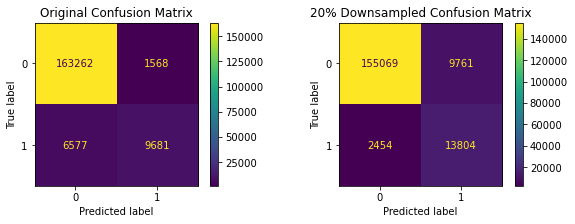


Original data classification report: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.98    164830
           1       0.86      0.60      0.70     16258

    accuracy                           0.96    181088
   macro avg       0.91      0.79      0.84    181088
weighted avg       0.95      0.96      0.95    181088


 20% Downsampled data classification report: 
               precision    recall  f1-score   support

           0       0.98      0.94      0.96    164830
           1       0.59      0.85      0.69     16258

    accuracy                           0.93    181088
   macro avg       0.79      0.89      0.83    181088
weighted avg       0.95      0.93      0.94    181088



In [63]:
#####################
### MODEL FITTING ###
#####################

# on the downsampled data
churn_logit_down_bal_20 = LogisticRegression(solver='lbfgs', random_state=1, max_iter=10000)
churn_logit_down_bal_20.fit(X_train_down_bal_20, y_train_down_bal_20)

# evaluate downsampled logistic model on the original validation set
y_pred_down_bal_20 = churn_logit_down_bal_20.predict(X_validation) 

# classification report of downsampled predictions
report_downsampled_20 = classification_report(y_validation, y_pred_down_bal_20)


#####################
### PRINT RESULTS ###
#####################

print_line = "\n=======================================================\n"

# Confusion matrices
print("Confusion matrices:", print_line)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Model on the original data
plot_confusion_matrix(churn_logit, X_validation, y_validation, ax=axes[0])
axes[0].set_title('Original Confusion Matrix')

# Model on the upsampled data
plot_confusion_matrix(churn_logit_down_bal_20, X_validation, y_validation, ax=axes[1])
axes[1].set_title('20% Downsampled Confusion Matrix')

plt.show()

# Classification Reports
print("\nOriginal data classification report:", print_line, report_initial)
print("\n 20% Downsampled data classification report:", print_line, report_downsampled_20)

Our initial downsampled logistic model with a sampling rate of 20% has not improved model performance on the validation set when compared to the original model on the imbalanced data. The f1-score has gone down by 1%, and the precision has gone down by 27% but the recall has improved by 25%. Compared to the 10% downsampled model, this model has increased model performance overall: Precision has gone up by 9% (from 50% to 59%) and the f1-score by 5% (from 64% to 69%), while recall has slightly gone down by 4% (from 89% to 85%). Compared to the 20% upsampled model, this model has slightly lower performance. The 20% model has an f1-score of 73%, so it has dropped by 4% for this model. Precision and recall are the same for both this model and the 20% upsampled. Thus, so far the 20% upsampled model is the best. 

---

## Pipelines and Hyperparameter Optimization on Data with All Features


**Using AUC**

Up until now we have been looking at the precision, recall, and f1-scores which all use the hard predictions. We can also consider the AUC score which uses soft predictions. We will apply this here on our scaled and optimized logistic models. 

**Note**
- The reason we do not simply use accuracy is because we have class imbalance. Accuracy measures the fraction of points our model gets correct for a fixed threshold, but this  can lead us to a false sense of confidence.  

- AUC, on the other hand, is the probability that when our model is given two random points, one from the positive (churn=1) class and one from the negative (churn=0) class, our model is more confident that the positive churn point belongs to the positive churn class than the negative no churn point belonging to the positive churn class.

- With AUC we are protected from class imbalances.

### Base Scaled and Optimized Logistic Model on Data with All Features

In [81]:
# Logistic Regression Pipeline
cachedir = mkdtemp()
base_estimators = [('normalise', StandardScaler()),
              ('model', LogisticRegression())]

pipe = Pipeline(base_estimators, memory = cachedir)

param_grid = [
            {'model': [LogisticRegression()], 
             'normalise': [StandardScaler()],
             'model__C': 10**np.arange(-5, 5, dtype=float)}
]

# Gridsearch with 5-fold cross validation 
# changing the default scoring metric  
# now each cv score calculates the AUC score NOT accuracy 
grid = GridSearchCV(pipe, param_grid, cv = 5, verbose = 2, scoring = 'roc_auc')

# Fitting our imbalanced dataset first to have a baseline optimized model
fittedgrid = grid.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model=LogisticRegression(), model__C=1e-05, normalise=StandardScaler(); total time=   2.4s
[CV] END model=LogisticRegression(), model__C=1e-05, normalise=StandardScaler(); total time=   1.3s
[CV] END model=LogisticRegression(), model__C=1e-05, normalise=StandardScaler(); total time=   1.3s
[CV] END model=LogisticRegression(), model__C=1e-05, normalise=StandardScaler(); total time=   1.4s
[CV] END model=LogisticRegression(), model__C=1e-05, normalise=StandardScaler(); total time=   1.4s
[CV] END model=LogisticRegression(), model__C=0.0001, normalise=StandardScaler(); total time=   1.1s
[CV] END model=LogisticRegression(), model__C=0.0001, normalise=StandardScaler(); total time=   1.8s
[CV] END model=LogisticRegression(), model__C=0.0001, normalise=StandardScaler(); total time=   1.3s
[CV] END model=LogisticRegression(), model__C=0.0001, normalise=StandardScaler(); total time=   1.1s
[CV] END model=LogisticRegression()

/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(), model__C=10.0, normalise=StandardScaler(); total time=   3.2s
[CV] END model=LogisticRegression(), model__C=100.0, normalise=StandardScaler(); total time=   3.1s
[CV] END model=LogisticRegression(), model__C=100.0, normalise=StandardScaler(); total time=   3.7s
[CV] END model=LogisticRegression(), model__C=100.0, normalise=StandardScaler(); total time=   3.3s
[CV] END model=LogisticRegression(), model__C=100.0, normalise=StandardScaler(); total time=   2.7s
[CV] END model=LogisticRegression(), model__C=100.0, normalise=StandardScaler(); total time=   3.5s
[CV] END model=LogisticRegression(), model__C=1000.0, normalise=StandardScaler(); total time=   2.8s
[CV] END model=LogisticRegression(), model__C=1000.0, normalise=StandardScaler(); total time=   3.1s
[CV] END model=LogisticRegression(), model__C=1000.0, normalise=StandardScaler(); total time=   3.6s
[CV] END model=LogisticRegression(), model__C=1000.0, normalise=StandardScaler(); total time=   2.

In [82]:
fittedgrid.best_estimator_

Pipeline(memory='/var/folders/5k/bd6ybgj9359gmn4ggk9l01_r0000gn/T/tmp_o2zyifu',
         steps=[('normalise', StandardScaler()),
                ('model', LogisticRegression(C=100.0))])

Our base model on the imbalanced data with all features has been optimized with C=100.  

In [88]:
fittedgrid.best_score_

0.9652054049974961

In [89]:
fittedgrid.cv_results_['mean_test_score']

array([0.93536127, 0.94687273, 0.96035548, 0.96461261, 0.96517403,
       0.96520281, 0.96520433, 0.9652054 , 0.9652052 , 0.9652053 ])

Our scaled and optimized base model on the imbalanced data with all features has the best AUC validation score across all folds of 96.5%. 

In [169]:
#sanity check: coefficient and feature shape matchup
fittedgrid_coeff.shape

(1, 22)

In [74]:
X_train.shape

(422537, 36)

It looks like our pipline gridsearch did not retain all 36 features. Let's re-fit a base scaled and optimized logistic model.

#### Original Model Fit with Scaling and Hyperparameter Optimization C= 100

In [177]:
# Scale the imbalanced data
original_ss = StandardScaler()
original_ss.fit(X_train)
X_train_ss = original_ss.transform(X_train)
X_validation_original_ss = original_ss.transform(X_validation)

In [178]:
# on the original data
original_ss_C = LogisticRegression(solver='lbfgs', random_state=1, C =100, max_iter=10000)
original_ss_C.fit(X_train_ss, y_train)

# evaluate on the original test set
y_pred_original_ss = original_ss_C.predict(X_validation_original_ss)

# classification report
original_ss_C_report = classification_report(y_validation, y_pred_original_ss)

---

### Upsampled Scaled and Optimized Logistic Model with 20% sampling rate

#### AUC score, ROC_AUC curve, Classification Report of Precision, Recall, F1-Score

Now let's fit the grid on the upsampled dataset (all features). This will normalize using the Standard scaler in the pipeline for every cv fold and give us the best optimal C value. Furthermore, we can get the AUC score on both the upsampled train and validation sets as well as the upsampled classification report. 

In [98]:
up_bal_20_model= grid.fit(X_train_up_bal_20, y_train_up_bal_20)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model=LogisticRegression(C=100.0), model__C=1e-05, normalise=StandardScaler(); total time=   3.2s
[CV] END model=LogisticRegression(C=100.0), model__C=1e-05, normalise=StandardScaler(); total time=   1.8s
[CV] END model=LogisticRegression(C=100.0), model__C=1e-05, normalise=StandardScaler(); total time=   1.9s
[CV] END model=LogisticRegression(C=100.0), model__C=1e-05, normalise=StandardScaler(); total time=   1.9s
[CV] END model=LogisticRegression(C=100.0), model__C=1e-05, normalise=StandardScaler(); total time=   1.8s
[CV] END model=LogisticRegression(C=100.0), model__C=0.0001, normalise=StandardScaler(); total time=   1.7s
[CV] END model=LogisticRegression(C=100.0), model__C=0.0001, normalise=StandardScaler(); total time=   1.5s
[CV] END model=LogisticRegression(C=100.0), model__C=0.0001, normalise=StandardScaler(); total time=   2.3s
[CV] END model=LogisticRegression(C=100.0), model__C=0.0001, normalise=StandardS

In [99]:
up_bal_20_model.best_estimator_

Pipeline(memory='/var/folders/5k/bd6ybgj9359gmn4ggk9l01_r0000gn/T/tmp_o2zyifu',
         steps=[('normalise', StandardScaler()),
                ('model', LogisticRegression(C=1000.0))])

The best upsampled model has been scaled and optimized with C= 1000 for the data with all features.

In [101]:
up_bal_20_model.cv_results_['mean_test_score']

array([0.93090815, 0.94750115, 0.96244231, 0.96823649, 0.96903428,
       0.96907952, 0.96908492, 0.9690844 , 0.96908521, 0.96908507])

In [100]:
up_bal_20_model.best_score_

0.9690852091615703

The best AUC validation score for this model is 97%! This is an improvement from the base.

In [173]:
up_bal_20_model_coeff= up_bal_20_model.best_estimator_.named_steps["model"].coef_

In [174]:
up_bal_20_model_coeff.shape

(1, 22)

As expected, he pipeline gridsearch did not retain all of the features. This will not affect the ROC curve or AUC scores by much but it will be a problem for the final feature coefficient importance and odds ratio since the coefficients will not match up with the features in X_train. So, let's re-fit a Logistic Model with C=1000 on our 20% upsampled data and calculate the AUC score, classification report, and plot out the confusion matrix and ROC curves. 

### Upsampled Model Fit With Hyperparameter Optimization

In [179]:
# Scale the upsampled data
my_ss = StandardScaler()
my_ss.fit(X_train_up_bal_20)
X_train_up_bal_20_ss = my_ss.transform(X_train_up_bal_20)
X_validation_ss = my_ss.transform(X_validation)

/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [180]:
#####################
### MODEL FITTING ###
#####################
# Fit Logistic model on the upsampled data having 20% upsampling rate
churn_logit_up_bal_20_C = LogisticRegression(solver='lbfgs', random_state=1, C=1000, max_iter=10000)
churn_logit_up_bal_20_C.fit(X_train_up_bal_20_ss, y_train_up_bal_20)

# evaluate on the transformed validation set
y_pred_up_bal_20_ss = churn_logit_up_bal_20_C.predict(X_validation_ss) 

# validation classification report
report_upsampled_20_ss = classification_report(y_validation, y_pred_up_bal_20_ss)

### Confusion Matrix, Classification Reports, and ROC_AUC Score of Original and 20% Upsampled after Scaling and Optimizing Hyperparameter C

Confusion matrices: 



/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


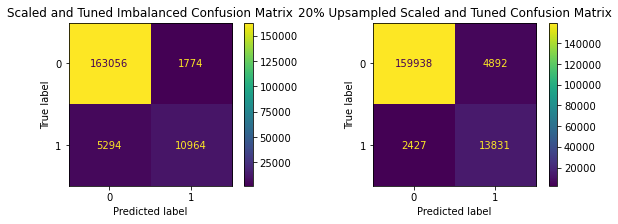


Original imbalanced data scaled and tuned (C=100) having all features classification report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98    164830
           1       0.86      0.67      0.76     16258

    accuracy                           0.96    181088
   macro avg       0.91      0.83      0.87    181088
weighted avg       0.96      0.96      0.96    181088


 20% Upsampled data scaled and tuned (C=1000) having all features classification report: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    164830
           1       0.74      0.85      0.79     16258

    accuracy                           0.96    181088
   macro avg       0.86      0.91      0.88    181088
weighted avg       0.96      0.96      0.96    181088



In [184]:
#####################
### PRINT RESULTS ###
#####################

print_line = "\n=======================================================\n"

# Confusion matrices
print("Confusion matrices:", print_line)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Model on the original data
plot_confusion_matrix(original_ss_C, X_validation_original_ss, y_validation, ax=axes[0])
axes[0].set_title('Scaled and Tuned Imbalanced Confusion Matrix')

# Model on the 20% upsampled data
plot_confusion_matrix(churn_logit_up_bal_20_C, X_validation_ss, y_validation, ax=axes[1])
axes[1].set_title('20% Upsampled Scaled and Tuned Confusion Matrix')

plt.show()

# Classification Reports
print("\nOriginal imbalanced data scaled and tuned (C=100) having all features classification report:", print_line, original_ss_C_report)
print("\n 20% Upsampled data scaled and tuned (C=1000) having all features classification report:", print_line, report_upsampled_20_ss)

After scaling and optimizing the C parameter, our upsampled logistic model with a sampling rate of 20% has improved model performance on the validation set. The baseline scaled and optimized model (C=100) on the imbalanced data has an f1-score of 76%, so our upsampled model has improved this by 3%, coming in at an f1-score of 79%. The recall has also improved from 67% baseline to 85% while precision went from 86% baseline to 74%. Compared to the previous upsampled model with a sampling rate of 20% that was not scaled or optimized, this model has improved on all metrics. Our biggest problem area was in precision, which has gone up by 10% (from 64% to 74%). The f1-score has also improved by 6% (from 73% to 79%). Overall, this is our best model. But, let's check downsampling as well (though we do not expect a difference). 

---

**ROC_AUC Score**

In [215]:
y_proba_train_up_bal_20_ss = churn_logit_up_bal_20_C.predict_proba(X_train_up_bal_20_ss)[:, 1]
y_proba_val_up_bal_20_ss = churn_logit_up_bal_20_C.predict_proba(X_validation_ss)[:, 1]

 # Score (AUC)
auc_train = np.round(roc_auc_score(y_train_up_bal_20, y_proba_train_up_bal_20_ss), 3)
auc_val = np.round(roc_auc_score(y_validation, y_proba_val_up_bal_20_ss), 3)

print(f'20% Upsampled Scaled and Tuned Train AUC score:',{auc_train})
print(f'20% Upsampled Scaled and Tuned Validation AUC score:',{auc_val})

20% Upsampled Scaled and Tuned Train AUC score: {0.969}
20% Upsampled Scaled and Tuned Validation AUC score: {0.969}


/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


Area under curve (AUC):0.969


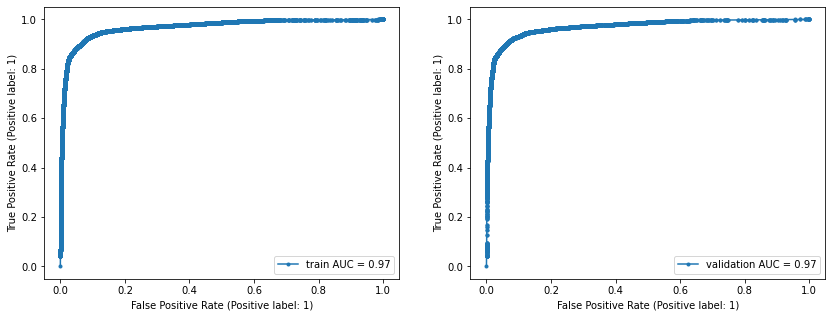

In [223]:
fig, axes = plt.subplots(1,2, figsize=(14, 5))
plot_roc_curve(churn_logit_up_bal_20_C, X_train_up_bal_20_ss, y_train_up_bal_20, ax=axes[0], marker='.', label='train AUC = %0.2f' % auc_train)
plot_roc_curve(churn_logit_up_bal_20_C, X_validation_ss, y_validation, ax=axes[1], marker='.', label='validation AUC = %0.2f' % auc_val)
print(f'Area under curve (AUC):{auc_train}')
plt.show()

---

### 20% Downsample Logistic Regression Pipeline Hyperparameter Optimization on Dataset with All Features
#### AUC score, ROC_AUC curve, Classification Report of Precision, Recall, F1-Score

In [128]:
down_bal_20_model= grid.fit(X_train_down_bal_20, y_train_down_bal_20)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model=LogisticRegression(C=1000.0), model__C=1e-05, normalise=StandardScaler(); total time=   0.6s
[CV] END model=LogisticRegression(C=1000.0), model__C=1e-05, normalise=StandardScaler(); total time=   0.3s
[CV] END model=LogisticRegression(C=1000.0), model__C=1e-05, normalise=StandardScaler(); total time=   0.3s
[CV] END model=LogisticRegression(C=1000.0), model__C=1e-05, normalise=StandardScaler(); total time=   0.3s
[CV] END model=LogisticRegression(C=1000.0), model__C=1e-05, normalise=StandardScaler(); total time=   0.3s
[CV] END model=LogisticRegression(C=1000.0), model__C=0.0001, normalise=StandardScaler(); total time=   0.2s
[CV] END model=LogisticRegression(C=1000.0), model__C=0.0001, normalise=StandardScaler(); total time=   0.2s
[CV] END model=LogisticRegression(C=1000.0), model__C=0.0001, normalise=StandardScaler(); total time=   0.2s
[CV] END model=LogisticRegression(C=1000.0), model__C=0.0001, normalise=

/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END model=LogisticRegression(C=1000.0), model__C=1000.0, normalise=StandardScaler(); total time=   0.8s
[CV] END model=LogisticRegression(C=1000.0), model__C=1000.0, normalise=StandardScaler(); total time=   0.7s
[CV] END model=LogisticRegression(C=1000.0), model__C=1000.0, normalise=StandardScaler(); total time=   0.8s
[CV] END model=LogisticRegression(C=1000.0), model__C=10000.0, normalise=StandardScaler(); total time=   0.8s
[CV] END model=LogisticRegression(C=1000.0), model__C=10000.0, normalise=StandardScaler(); total time=   0.7s
[CV] END model=LogisticRegression(C=1000.0), model__C=10000.0, normalise=StandardScaler(); total time=   0.8s
[CV] END model=LogisticRegression(C=1000.0), model__C=10000.0, normalise=StandardScaler(); total time=   0.7s
[CV] END model=LogisticRegression(C=1000.0), model__C=10000.0, normalise=StandardScaler(); total time=   0.6s


In [129]:
down_bal_20_model.best_estimator_

Pipeline(memory='/var/folders/5k/bd6ybgj9359gmn4ggk9l01_r0000gn/T/tmp_o2zyifu',
         steps=[('normalise', StandardScaler()),
                ('model', LogisticRegression(C=1000.0))])

In [130]:
down_bal_20_model.best_score_

0.9682420658220448

In [131]:
down_bal_20_model.cv_results_['mean_test_score']

array([0.91295344, 0.93778068, 0.95125035, 0.9647771 , 0.96782597,
       0.9682118 , 0.96823882, 0.96824141, 0.96824207, 0.96824173])

The downsampled scaled an d optimized model has practically the same AUC validation score as the upsampling (roughly 97%). Downsampling is less computationally expensive so it is the best model so far in terms of performance and computation speed. 

/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted withou

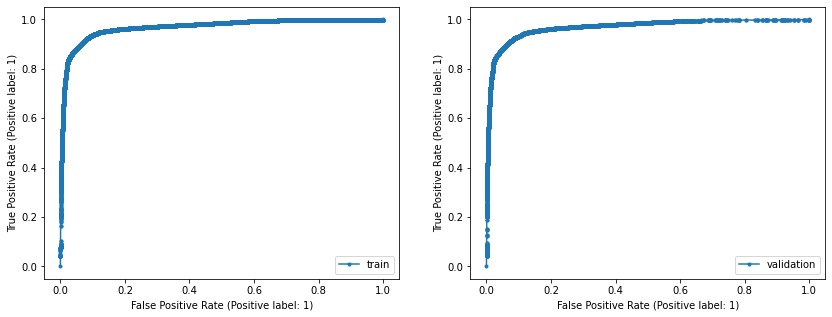

In [132]:
fig, axes = plt.subplots(1,2, figsize=(14, 5))
plot_roc_curve(down_bal_20_model, X_train_down_bal_20, y_train_down_bal_20, ax=axes[0], marker='.', label='train')
plot_roc_curve(down_bal_20_model, X_validation, y_validation, ax=axes[1], marker='.', label='validation')
#print(f'Area under curve (AUC):{roc_auc}')
plt.show()

### Downsampled Model Fit With Hyperparameter Optimization

In [225]:
# Scale the downsampled data
my_ss_down = StandardScaler()
my_ss_down.fit(X_train_down_bal_20)
X_train_down_bal_20_ss = my_ss_down.transform(X_train_down_bal_20)
X_validation_down_ss = my_ss_down.transform(X_validation)

/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [226]:
#####################
### MODEL FITTING ###
#####################
# Fit Logistic model on the upsampled data having 20% upsampling rate
churn_logit_down_bal_20_C = LogisticRegression(solver='lbfgs', random_state=1, C=1000, max_iter=10000)
churn_logit_down_bal_20_C.fit(X_train_down_bal_20_ss, y_train_down_bal_20)

# evaluate on the transformed validation set
y_pred_down_bal_20_ss = churn_logit_down_bal_20_C.predict(X_validation_down_ss) 

# validation classification report
report_downsampled_20_ss = classification_report(y_validation, y_pred_down_bal_20_ss)

### Confusion Matrix, Classification Reports, and ROC_AUC Score of Original and 20% Upsampled after Scaling and Optimizing Hyperparameter C

Confusion matrices: 



/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


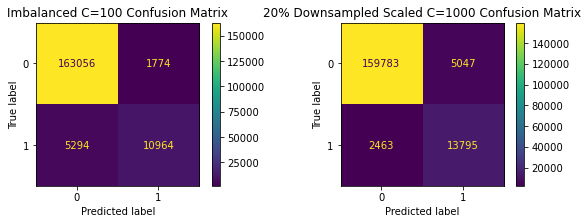


Original imbalanced data scaled and tuned (C=100) having all features classification report: 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98    164830
           1       0.86      0.67      0.76     16258

    accuracy                           0.96    181088
   macro avg       0.91      0.83      0.87    181088
weighted avg       0.96      0.96      0.96    181088


20% Downsampled data scaled and tuned (C=1000) having all features classification report: 
               precision    recall  f1-score   support

           0       0.99      0.97      0.98    164830
           1       0.74      0.85      0.79     16258

    accuracy                           0.96    181088
   macro avg       0.86      0.91      0.88    181088
weighted avg       0.96      0.96      0.96    181088



In [232]:
#####################
### PRINT RESULTS ###
#####################

print_line = "\n=======================================================\n"

# Confusion matrices
print("Confusion matrices:", print_line)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Model on the original data with all features
plot_confusion_matrix(original_ss_C, X_validation_original_ss, y_validation, ax=axes[0])
axes[0].set_title('Imbalanced C=100 Confusion Matrix')

# Model on the 20% downsampled data with all features
plot_confusion_matrix(churn_logit_down_bal_20_C, X_validation_down_ss, y_validation, ax=axes[1])
axes[1].set_title('20% Downsampled Scaled C=1000 Confusion Matrix')

plt.show()

# Classification Reports
print("\nOriginal imbalanced data scaled and tuned (C=100) having all features classification report:", print_line, original_ss_C_report)
print("\n20% Downsampled data scaled and tuned (C=1000) having all features classification report:", print_line, report_upsampled_20_ss)

After scaling and optimizing the C parameter, our downsampled logistic model with a sampling rate of 20% has improved model performance on the validation set. The baseline scaled and optimized model (C=100) on the imbalanced data has an f1-score of 76%, so our downsampled model has improved this by 3%, coming in at an f1-score of 79%. The recall has also improved from 67% baseline to 85% while precision went from 86% baseline to 74%. Compared to the previous downsampled model that was not scaled or optimized, this model has improved on all metrics. We can especially see a 15% improvement in the precision where the previous 20% downsampled model was lacking (went from 59% to 74% precision). The recall has remained the same. The f1-score has gone up by 10% (from 69% to 79%). Finally, this model is no different than the results we obtained with the 20% upsampled scaled and optimized model so we are safe to between choose either. Since downsampling runs faster this is the only thing we can gain.  

---

### Feature Selected Dataset: Sampling and Logistic Model 
#### Hyperparameter Optimization with ROC_AUC metric, and Precision, Recall, F1-Score Classification Report

In this section, we apply the same sampling techniques and model fits as before but on our other dataset. This dataset was further reduced down to 22 features in the Feature Engineering notebook by removing features that introduced multicollinearity. Our goal in this section is to see if model performance improves (or stays roughly the same) having less features, and hopefully more important features in predicting churn.

We begin by reading in the pickled dataset with feature selection:

In [37]:
sel_data = pd.read_pickle('sel_data.pkl')

In [136]:
sel_data.head()

,Reg_3,Reg_4,Reg_9,pay_39,pay_40,msno,is_churn,is_cancel,is_discount,amt_per_day,...,percent_50,reg_month,trans_weekday,trans_month,mem_exp_day,mem_exp_weekday,mem_exp_month,user__weekday,user__month,user__year
0,1,0,0,0,0,ugx0CjOMzazClkFzU2xasmDZaoIqOUAZPsH1q0teWCg=,1,0,0,4.966667,...,0.0000,12,1,2,30,3,3,6,3,2017
1,1,0,0,0,0,f/NmvEzHfhINFEYZTR05prUdr+E+3+oewvweYz9cCQE=,1,0,0,6.000000,...,0.5000,12,5,3,11,1,4,0,3,2017
2,1,0,0,0,0,zLo9f73nGGT1p21ltZC3ChiRnAVvgibMyazbCxvWPcg=,1,0,0,3.333333,...,0.0625,12,1,3,15,3,6,3,3,2017
4,0,0,0,0,0,K6fja4+jmoZ5xG6BypqX80Uw/XKpMgrEMdG2edFOxnA=,1,0,0,3.300000,...,0.0000,1,3,3,18,0,9,5,3,2017
5,1,0,0,0,1,ibIHVYBqxGwrSExE63/omeDD99M5vYB3CN2HzkEY+eM=,1,1,0,4.966667,...,0.0000,1,3,3,14,1,3,2,3,2017


In [141]:
sel_data.shape

(754532, 24)

Then we separate the data into X and the target variable y (churn):

In [38]:
X_sel = sel_data.drop(['is_churn', 'msno'], axis=1)
y_sel = sel_data['is_churn']

Just as before, we perform a remainder-test split and then a train-validation split:

In [39]:
X_sel_remainder, X_sel_test, y_sel_remainder, y_sel_test = train_test_split(X_sel,y_sel, test_size=0.2, random_state=1)

In [40]:
# Splitting the remainder in two chunks
X_sel_train, X_sel_val, y_sel_train, y_sel_val = \
    train_test_split(X_sel_remainder, y_sel_remainder, test_size = 0.3,
                     random_state=1, stratify= y_sel_remainder)

In [140]:
X_sel_train.shape, X_sel_val.shape, y_sel_train.shape, y_sel_val.shape

((422537, 22), (181088, 22), (422537,), (181088,))

---

### Upsampling on Selected Dataset

In [142]:
print('Number of class 1 examples of dataset with feature selction before sampling:', X_sel_train[y_sel_train == 1].shape[0])

Number of class 1 examples of dataset with feature selction before sampling: 37934


In [143]:
X_sel_upsampled_20, y_sel_upsampled_20 = resample(X_sel_train[y_sel_train == 1], 
                                    y_sel_train[y_sel_train == 1], 
                                    replace=True, 
                                    n_samples= round((X_sel_train[y_sel_train == 1].shape[0])/0.2), 
                                    random_state=1)

print('Number of class 1 examples of dataset with feature selction after upsampling:', X_sel_upsampled_20.shape[0])

# Combine upsample with original data
X_sel_train_up_bal_20 = np.vstack((X_sel_train[y_sel_train == 0], X_sel_upsampled_20))
y_sel_train_up_bal_20 = np.hstack((y_sel_train[y_sel_train == 0], y_sel_upsampled_20))

Number of class 1 examples of dataset with feature selction after upsampling: 189670


### Downsampling on Selected Dataset

In [145]:
# Downsample
print('Number of class 0 examples on dataset with feature selection before downsampling:', X_sel_train[y_sel_train == 0].shape[0])

X_sel_downsampled_20, y_sel_downsampled_20 = resample(X_sel_train[y_sel_train == 0], 
                                        y_sel_train[y_sel_train == 0], 
                                        replace=True, 
                                        n_samples= round(X_sel_train[y_sel_train == 0].shape[0]*0.2), 
                                        random_state=1)

print('Number of class 0 examples on dataset with feature selection after downsampling:', X_sel_downsampled_20.shape[0])

print('Downsampling Rate:', X_sel_downsampled_20.shape[0]/X_sel_train[y_sel_train == 0].shape[0])
# Combine downsample with original data
X_sel_train_down_bal_20 = np.vstack((X_sel_train[y_train == 1], X_sel_downsampled_20))
y_sel_train_down_bal_20 = np.hstack((y_sel_train[y_train == 1], y_sel_downsampled_20))

Number of class 0 examples on dataset with feature selection before downsampling: 384603
Number of class 0 examples on dataset with feature selection after downsampling: 76921
Downsampling Rate: 0.2000010400334891


---

### Base Logistic Model using Pipeline and Hyperparameter Optimization on Data with Feature Selection

In [144]:
base_sel_model= grid.fit(X_sel_train, y_sel_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model=LogisticRegression(C=1000.0), model__C=1e-05, normalise=StandardScaler(); total time=   1.2s
[CV] END model=LogisticRegression(C=1000.0), model__C=1e-05, normalise=StandardScaler(); total time=   1.2s
[CV] END model=LogisticRegression(C=1000.0), model__C=1e-05, normalise=StandardScaler(); total time=   1.6s
[CV] END model=LogisticRegression(C=1000.0), model__C=1e-05, normalise=StandardScaler(); total time=   1.4s
[CV] END model=LogisticRegression(C=1000.0), model__C=1e-05, normalise=StandardScaler(); total time=   1.1s
[CV] END model=LogisticRegression(C=1000.0), model__C=0.0001, normalise=StandardScaler(); total time=   1.2s
[CV] END model=LogisticRegression(C=1000.0), model__C=0.0001, normalise=StandardScaler(); total time=   1.1s
[CV] END model=LogisticRegression(C=1000.0), model__C=0.0001, normalise=StandardScaler(); total time=   1.0s
[CV] END model=LogisticRegression(C=1000.0), model__C=0.0001, normalise=

In [146]:
base_sel_model.best_estimator_

Pipeline(memory='/var/folders/5k/bd6ybgj9359gmn4ggk9l01_r0000gn/T/tmp_o2zyifu',
         steps=[('normalise', StandardScaler()),
                ('model', LogisticRegression(C=10000.0))])

In [147]:
base_sel_model.best_score_

0.9558903739301432

In [148]:
base_sel_model.cv_results_['mean_test_score']

array([0.93291926, 0.93815224, 0.94707652, 0.95442826, 0.95570937,
       0.95587214, 0.95588854, 0.95589019, 0.95589036, 0.95589037])

Our base scaled and optimized logistic model (C=10,000) has a best AUC validation score across all 5 cv folds of 95.6% for our imbalanced data with feature selection. This result is not different from when we had all features, so we would be safe so far in having less features and still retaining a high AUC score. 

/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.w

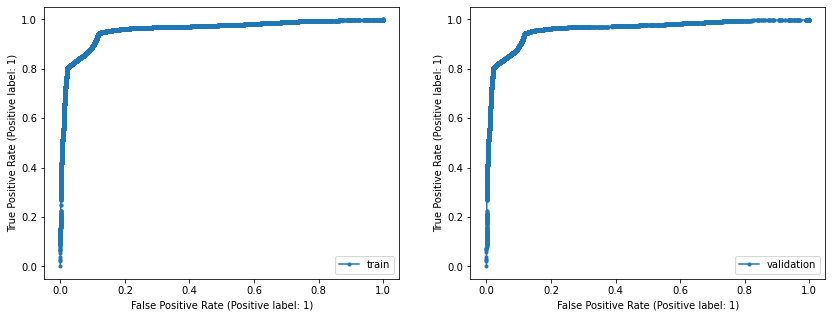

In [154]:
fig, axes = plt.subplots(1,2, figsize=(14, 5))
plot_roc_curve(base_sel_model, X_sel_train, y_sel_train, ax=axes[0], marker='.', label='train')
plot_roc_curve(base_sel_model, X_sel_val, y_sel_val, ax=axes[1], marker='.', label='validation')
#print(f'Area under curve (AUC):{roc_auc}')
plt.show()

---

### Base Model Fit with Hyperparameter Optimization on Dataset with Feature Selection

In [244]:
# Scale the imbalanced data
base_ss = StandardScaler()
base_ss.fit(X_sel_train)
X_sel_train_ss = base_ss.transform(X_sel_train)
X_sel_val_base_ss = base_ss.transform(X_sel_val)

In [245]:
# fit base model with C= 10,000
base_ss_C = LogisticRegression(solver='lbfgs', random_state=1, C =10000, max_iter=10000)
base_ss_C.fit(X_sel_train_ss, y_sel_train)

# evaluate on the original test set
y_pred_base_ss = base_ss_C.predict(X_sel_val_base_ss)

# classification report
base_ss_C_report = classification_report(y_sel_val, y_pred_base_ss)

---

### Upsample Pipeline Hyperparameter Optimization on Feature Selected Data

In [149]:
up_sel_bal_20_model= grid.fit(X_sel_train_up_bal_20, y_sel_train_up_bal_20)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model=LogisticRegression(C=10000.0), model__C=1e-05, normalise=StandardScaler(); total time=   1.8s
[CV] END model=LogisticRegression(C=10000.0), model__C=1e-05, normalise=StandardScaler(); total time=   2.2s
[CV] END model=LogisticRegression(C=10000.0), model__C=1e-05, normalise=StandardScaler(); total time=   2.9s
[CV] END model=LogisticRegression(C=10000.0), model__C=1e-05, normalise=StandardScaler(); total time=   1.6s
[CV] END model=LogisticRegression(C=10000.0), model__C=1e-05, normalise=StandardScaler(); total time=   1.7s
[CV] END model=LogisticRegression(C=10000.0), model__C=0.0001, normalise=StandardScaler(); total time=   0.8s
[CV] END model=LogisticRegression(C=10000.0), model__C=0.0001, normalise=StandardScaler(); total time=   0.8s
[CV] END model=LogisticRegression(C=10000.0), model__C=0.0001, normalise=StandardScaler(); total time=   1.0s
[CV] END model=LogisticRegression(C=10000.0), model__C=0.0001, n

In [151]:
up_sel_bal_20_model.best_estimator_

Pipeline(memory='/var/folders/5k/bd6ybgj9359gmn4ggk9l01_r0000gn/T/tmp_o2zyifu',
         steps=[('normalise', StandardScaler()),
                ('model', LogisticRegression(C=0.1))])

In [152]:
up_sel_bal_20_model.best_score_

0.9589974436194467

In [153]:
up_sel_bal_20_model.cv_results_['mean_test_score']

array([0.93193731, 0.94011564, 0.94876819, 0.95881878, 0.95899744,
       0.95895581, 0.9589516 , 0.95895116, 0.95895112, 0.95895111])

The upsampled scaled and optimized (C=0.1) with a sampling rate of 20% on the data with feature selction has a best AUC validation score across all 5 cv folds of about 96% (slight improvement from base which had 95.5% to now 95.9%, but not significant increase). 

/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted withou

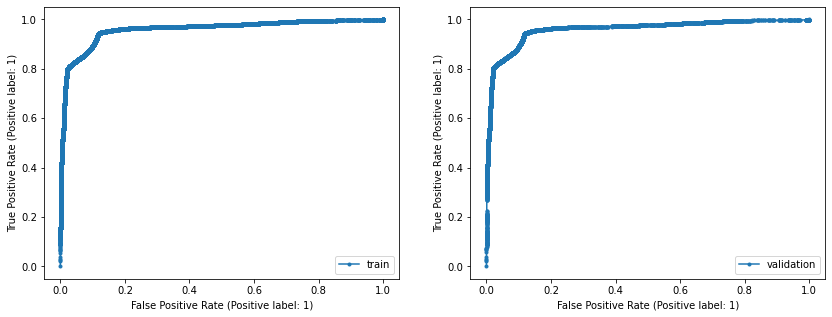

In [155]:
fig, axes = plt.subplots(1,2, figsize=(14, 5))
plot_roc_curve(up_sel_bal_20_model, X_sel_train_up_bal_20, y_sel_train_up_bal_20, ax=axes[0], marker='.', label='train')
plot_roc_curve(up_sel_bal_20_model, X_sel_val, y_sel_val, ax=axes[1], marker='.', label='validation')
#print(f'Area under curve (AUC):{roc_auc}')
plt.show()

---

### Upsampled Model Fit With Hyperparameter Optimization C=0.1 on Dataset with Feature Selection

In [246]:
# Scale the upsampled data
my_ss_up = StandardScaler()
my_ss_up.fit(X_sel_train_up_bal_20)
X_sel_train_up_bal_20_ss = my_ss_up.transform(X_sel_train_up_bal_20)
X_sel_val_ss = my_ss_up.transform(X_sel_val)

/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [250]:
#####################
### MODEL FITTING ###
#####################
# Fit Logistic model on the upsampled data having 20% upsampling rate
churn_logit_sel_up_bal_20_C = LogisticRegression(solver='lbfgs', random_state=1, C=0.1, max_iter=10000)
churn_logit_sel_up_bal_20_C.fit(X_sel_train_up_bal_20_ss, y_sel_train_up_bal_20)

# evaluate on the transformed validation set
y_pred_sel_up_bal_20_ss = churn_logit_sel_up_bal_20_C.predict(X_sel_val_ss) 

# validation classification report
report_sel_upsampled_20_ss = classification_report(y_sel_val, y_pred_sel_up_bal_20_ss)

### Confusion Matrix, Classification Reports, and ROC_AUC Score of Base and 20% Upsampled after Scaling and Optimizing Hyperparameter C for Feature Selected Data

Confusion matrices: 



/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


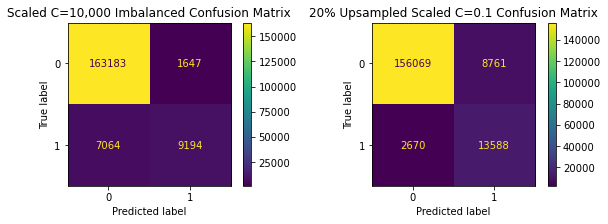


Base imbalanced data scaled and tuned (C=10,000) selected features classification report: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97    164830
           1       0.85      0.57      0.68     16258

    accuracy                           0.95    181088
   macro avg       0.90      0.78      0.83    181088
weighted avg       0.95      0.95      0.95    181088


 20% Upsampled data scaled and tuned (C=0.1) selected features classification report: 
               precision    recall  f1-score   support

           0       0.98      0.95      0.96    164830
           1       0.61      0.84      0.70     16258

    accuracy                           0.94    181088
   macro avg       0.80      0.89      0.83    181088
weighted avg       0.95      0.94      0.94    181088



In [253]:
#####################
### PRINT RESULTS ###
#####################

print_line = "\n=======================================================\n"

# Confusion matrices
print("Confusion matrices:", print_line)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Model on the original data
plot_confusion_matrix(base_ss_C, X_sel_val_base_ss, y_sel_val, ax=axes[0])
axes[0].set_title('Scaled C=10,000 Imbalanced Confusion Matrix')

# Model on the 20% upsampled data
plot_confusion_matrix(churn_logit_sel_up_bal_20_C, X_sel_val_ss, y_sel_val, ax=axes[1])
axes[1].set_title('20% Upsampled Scaled C=0.1 Confusion Matrix')

plt.show()

# Classification Reports
print("\nBase imbalanced data scaled and tuned (C=10,000) selected features classification report:", print_line, base_ss_C_report)
print("\n 20% Upsampled data scaled and tuned (C=0.1) selected features classification report:", print_line, report_sel_upsampled_20_ss)

We did slightly increase the f1-score on our upsampled model (from 68% to 70%), and recall improved a lot (from 57% to 84%) but in turn precision decreased (from 85% to 61%). There is not much deviation overall between the two models. If we choose f1-score as our overarching metric here, as it combines the precision and recall of a classifier into a single metric by taking their harmonic mean, then we can conclude that f1-score has gone up by 2% for our upsampled logistic model of the data with selected features. As well, the AUC score has remained at 96%. When compared to the 20% upsampled optimized logistic model on our data with all features, we do see slightly worse model performance: the f1-score has decreased by 9% (from 79% to 70%), the precision has dropped by 6% (from 86% to 80%), while the recall has dropped by 1% (from 85% to 84%).  

---

### Downsample Pipeline Hyperparameter Optimization on Feature Selected Data

In [157]:
down_sel_bal_20_model= grid.fit(X_sel_train_down_bal_20, y_sel_train_down_bal_20)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END model=LogisticRegression(C=0.1), model__C=1e-05, normalise=StandardScaler(); total time=   0.3s
[CV] END model=LogisticRegression(C=0.1), model__C=1e-05, normalise=StandardScaler(); total time=   0.4s
[CV] END model=LogisticRegression(C=0.1), model__C=1e-05, normalise=StandardScaler(); total time=   0.3s
[CV] END model=LogisticRegression(C=0.1), model__C=1e-05, normalise=StandardScaler(); total time=   0.4s
[CV] END model=LogisticRegression(C=0.1), model__C=1e-05, normalise=StandardScaler(); total time=   0.3s
[CV] END model=LogisticRegression(C=0.1), model__C=0.0001, normalise=StandardScaler(); total time=   0.2s
[CV] END model=LogisticRegression(C=0.1), model__C=0.0001, normalise=StandardScaler(); total time=   0.2s
[CV] END model=LogisticRegression(C=0.1), model__C=0.0001, normalise=StandardScaler(); total time=   0.2s
[CV] END model=LogisticRegression(C=0.1), model__C=0.0001, normalise=StandardScaler(); total tim

In [158]:
down_sel_bal_20_model.best_estimator_

Pipeline(memory='/var/folders/5k/bd6ybgj9359gmn4ggk9l01_r0000gn/T/tmp_o2zyifu',
         steps=[('normalise', StandardScaler()),
                ('model', LogisticRegression(C=10000.0))])

In [159]:
down_sel_bal_20_model.best_score_

0.9588059262945441

In [160]:
down_sel_bal_20_model.cv_results_['mean_test_score']

array([0.92596885, 0.93425046, 0.94140012, 0.9501875 , 0.95806733,
       0.95875215, 0.9588011 , 0.95880546, 0.95880587, 0.95880593])

Our downsampled scaled and optimized (C=10,000) logistic model with a sampling rate of 20% on our data with selected features has a best AUC validation score across all 5 cv folds of 95.9% which is the same as our upsampled model. We did get slightly better AUC scores for our data with all features (97%), but this is still very high so we would be ok in reducing features. 

/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)
/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted withou

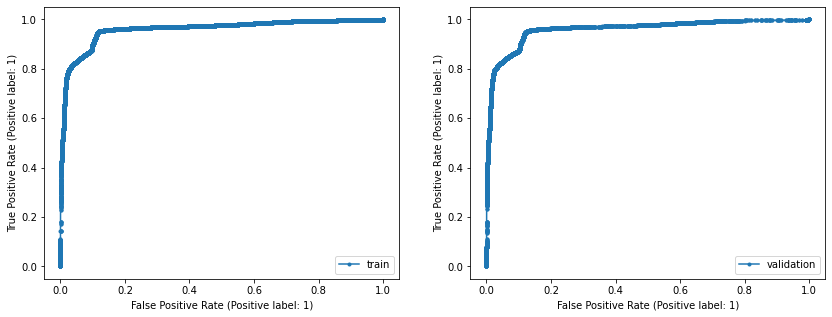

In [161]:
fig, axes = plt.subplots(1,2, figsize=(14, 5))
plot_roc_curve(down_sel_bal_20_model, X_sel_train_down_bal_20, y_sel_train_down_bal_20, ax=axes[0], marker='.', label='train')
plot_roc_curve(down_sel_bal_20_model, X_sel_val, y_sel_val, ax=axes[1], marker='.', label='validation')
#print(f'Area under curve (AUC):{roc_auc}')
plt.show()

In [248]:
# Scale the downsampled data with feature selection
my_ss_down = StandardScaler()
my_ss_down.fit(X_sel_train_down_bal_20)
X_sel_train_down_bal_20_ss = my_ss_down.transform(X_sel_train_down_bal_20)
X_sel_val_ss_down = my_ss_down.transform(X_sel_val)

/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [254]:
#####################
### MODEL FITTING ###
#####################
# Fit Logistic model on the downsampled data having 20% downsampling rate and C=10,000
churn_logit_sel_down_bal_20_C = LogisticRegression(solver='lbfgs', random_state=1, C=10000, max_iter=10000)
churn_logit_sel_down_bal_20_C.fit(X_sel_train_down_bal_20_ss, y_sel_train_down_bal_20)

# evaluate on the transformed validation set
y_pred_sel_down_bal_20_ss = churn_logit_sel_down_bal_20_C.predict(X_sel_val_ss_down) 

# validation classification report
report_sel_downsampled_20_ss = classification_report(y_sel_val, y_pred_sel_down_bal_20_ss)

Confusion matrices: 



/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/Users/danielamagiricu/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


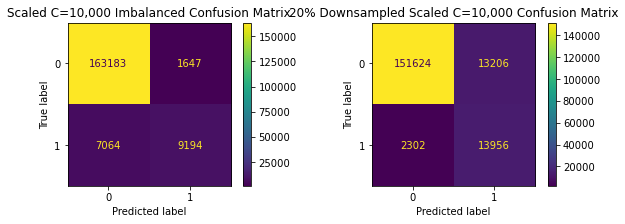


Base imbalanced data scaled and tuned (C=10,000) selected features classification report: 
               precision    recall  f1-score   support

           0       0.96      0.99      0.97    164830
           1       0.85      0.57      0.68     16258

    accuracy                           0.95    181088
   macro avg       0.90      0.78      0.83    181088
weighted avg       0.95      0.95      0.95    181088


 20% Downsampled data scaled and tuned (C=10,000) selected features classification report: 
               precision    recall  f1-score   support

           0       0.98      0.95      0.96    164830
           1       0.61      0.84      0.70     16258

    accuracy                           0.94    181088
   macro avg       0.80      0.89      0.83    181088
weighted avg       0.95      0.94      0.94    181088



In [255]:
#####################
### PRINT RESULTS ###
#####################

print_line = "\n=======================================================\n"

# Confusion matrices
print("Confusion matrices:", print_line)

fig, axes = plt.subplots(1, 2, figsize=(10, 3))

# Model on the original data
plot_confusion_matrix(base_ss_C, X_sel_val_base_ss, y_sel_val, ax=axes[0])
axes[0].set_title('Scaled C=10,000 Imbalanced Confusion Matrix')

# Model on the 20% upsampled data
plot_confusion_matrix(churn_logit_sel_down_bal_20_C, X_sel_val_ss_down, y_sel_val, ax=axes[1])
axes[1].set_title('20% Downsampled Scaled C=10,000 Confusion Matrix')

plt.show()

# Classification Reports
print("\nBase imbalanced data scaled and tuned (C=10,000) selected features classification report:", print_line, base_ss_C_report)
print("\n 20% Downsampled data scaled and tuned (C=10,000) selected features classification report:", print_line, report_sel_upsampled_20_ss)

There is no difference in these statistics between upsampling and downsampling. 

---

## Summary

### Best Model:
- Our best logistic model is either the scaled and optimized upsampling or downsampling with a sampling rate of 20% on our dataset with all features. 

- However, we do not lose much performance by reducing features in using our data with 22 selected features so we could also select either scaled and optimized upsampling or downsampling on our dataset with selected features.

- Final Decision: Optimized Downsampling with a sampling rate of 20% on our dataset with all features (advantage over upsampling is faster run time)

---

### Feature Coefficient Importance and Odds Ratio Visualizations

Finally, we will investigate the features and their coefficients as well as the odds ratio from our best models for both datasets to analyze which features are most important in driving our churn prediction.

#### Data with all features: 20% Downsampled Scaled and Optimized Logistic Model Coefficient and Odds Ratio Visuals

In [86]:
down_coef = churn_logit_down_bal_20_C.coef_
churn_logit_down_bal_20.coef_[0]

array([-7.92827700e-02,  4.80715632e-01, -2.04865331e-01, -2.32863997e-01,
       -2.65196086e-01, -3.54796257e-01,  1.41057153e-02,  6.83164163e-01,
       -2.77421798e-01,  1.12406127e+00,  3.45776996e+00,  2.41828783e-02,
       -1.62074603e-02, -2.36348695e-01,  3.29276316e-03, -2.33370869e+00,
       -2.33370869e+00, -2.19079547e-03, -1.75885186e-06,  4.37615214e-03,
       -3.95932030e-03, -1.50701418e-02, -3.69645805e-02, -3.13686183e-02,
       -5.55462093e-02, -8.69077665e-02,  2.27756749e-02, -2.99848231e+00,
       -7.66254827e-02,  7.36989117e-02,  1.32888472e-04,  2.90180805e+00,
       -1.35644117e-01,  1.77195133e-02,  3.98366181e-04,  2.67834863e-01])

In [87]:
X_train.columns

Index(['Reg_3', 'Reg_4', 'Reg_7', 'Reg_9', 'City_1', 'pay_38', 'pay_39',
       'pay_40', 'pay_41', 'is_auto_renew', 'is_cancel', 'discount',
       'is_discount', 'amt_per_day', 'membership_days',
       'autorenew_&_not_cancel', 'notAutorenew_&_cancel', 'num_unq',
       'total_secs', 'percent_25', 'percent_50', 'percent_100', 'last_log_day',
       'reg_month', 'reg_year', 'trans_day', 'trans_weekday', 'trans_month',
       'trans_year', 'mem_exp_day', 'mem_exp_weekday', 'mem_exp_month',
       'mem_exp_year', 'user__weekday', 'user__month', 'user__year'],
      dtype='object')

In [88]:
# Put the feature names and their coefficients into a data frame
down_coefficients_df = pd.DataFrame({'Features': X_train.columns,
                               'Coefficients': down_coef[0]})
down_coefficients_df.sort_values(by='Coefficients', ascending=False, inplace=True, ignore_index=True) # Sort Feature Coefficients in descending order

down_coefficients_df

,Features,Coefficients
0,membership_days,3.250749
1,mem_exp_month,3.175103
2,is_cancel,1.394827
3,last_log_day,1.131152
4,mem_exp_day,0.515213
5,discount,0.353013
6,Reg_4,0.244009
7,Reg_7,0.189245
8,Reg_3,0.176322
9,Reg_9,0.122774


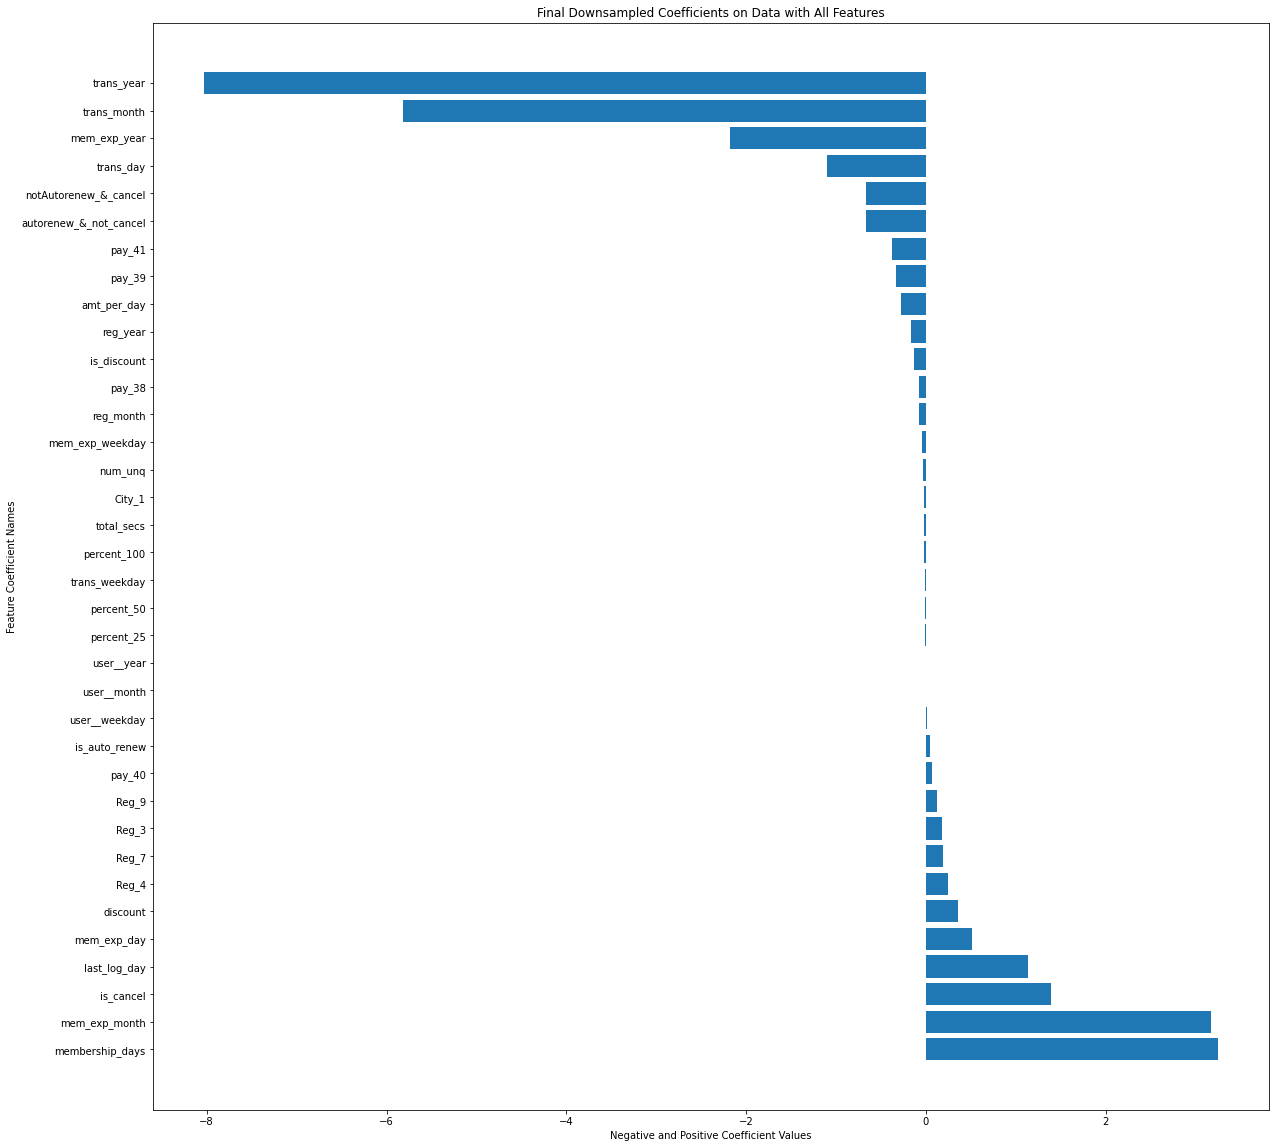

In [89]:
plt.figure(figsize=(20,20))
plt.barh(down_coefficients_df['Features'],down_coefficients_df['Coefficients'])
plt.title('Final Downsampled Coefficients on Data with All Features')
plt.ylabel('Feature Coefficient Names')
plt.xlabel('Negative and Positive Coefficient Values')
plt.show()

In [90]:
final_odds_ratio_down = np.exp(down_coef[0])
final_odds_ratio_down

array([1.19282209e+00, 1.27635639e+00, 1.20833650e+00, 1.13062892e+00,
       9.80308405e-01, 9.21645465e-01, 7.18895362e-01, 1.07002887e+00,
       6.85298046e-01, 1.04844070e+00, 4.03427581e+00, 1.42334917e+00,
       8.80134013e-01, 7.55685523e-01, 2.58096727e+01, 5.15266437e-01,
       5.15266437e-01, 9.72985320e-01, 9.80583181e-01, 9.94803704e-01,
       9.91049728e-01, 9.81118278e-01, 3.09922617e+00, 9.26014431e-01,
       8.51214565e-01, 3.31843964e-01, 9.86016696e-01, 2.98205496e-03,
       3.23712595e-04, 1.67399525e+00, 9.57546506e-01, 2.39292834e+01,
       1.13659435e-01, 1.01735441e+00, 1.00000000e+00, 1.00000000e+00])

In [91]:
# Put the feature names and their odds ratio into a data frame
down_odds_df = pd.DataFrame({'Features': X_train.columns,
                           'Odds Ratio': final_odds_ratio_down})
down_odds_df.sort_values(by='Odds Ratio', ascending=False, inplace=True, ignore_index=True) # Sort Feature Coefficients in descending order

down_odds_df

,Features,Odds Ratio
0,membership_days,25.809673
1,mem_exp_month,23.929283
2,is_cancel,4.034276
3,last_log_day,3.099226
4,mem_exp_day,1.673995
5,discount,1.423349
6,Reg_4,1.276356
7,Reg_7,1.208337
8,Reg_3,1.192822
9,Reg_9,1.130629


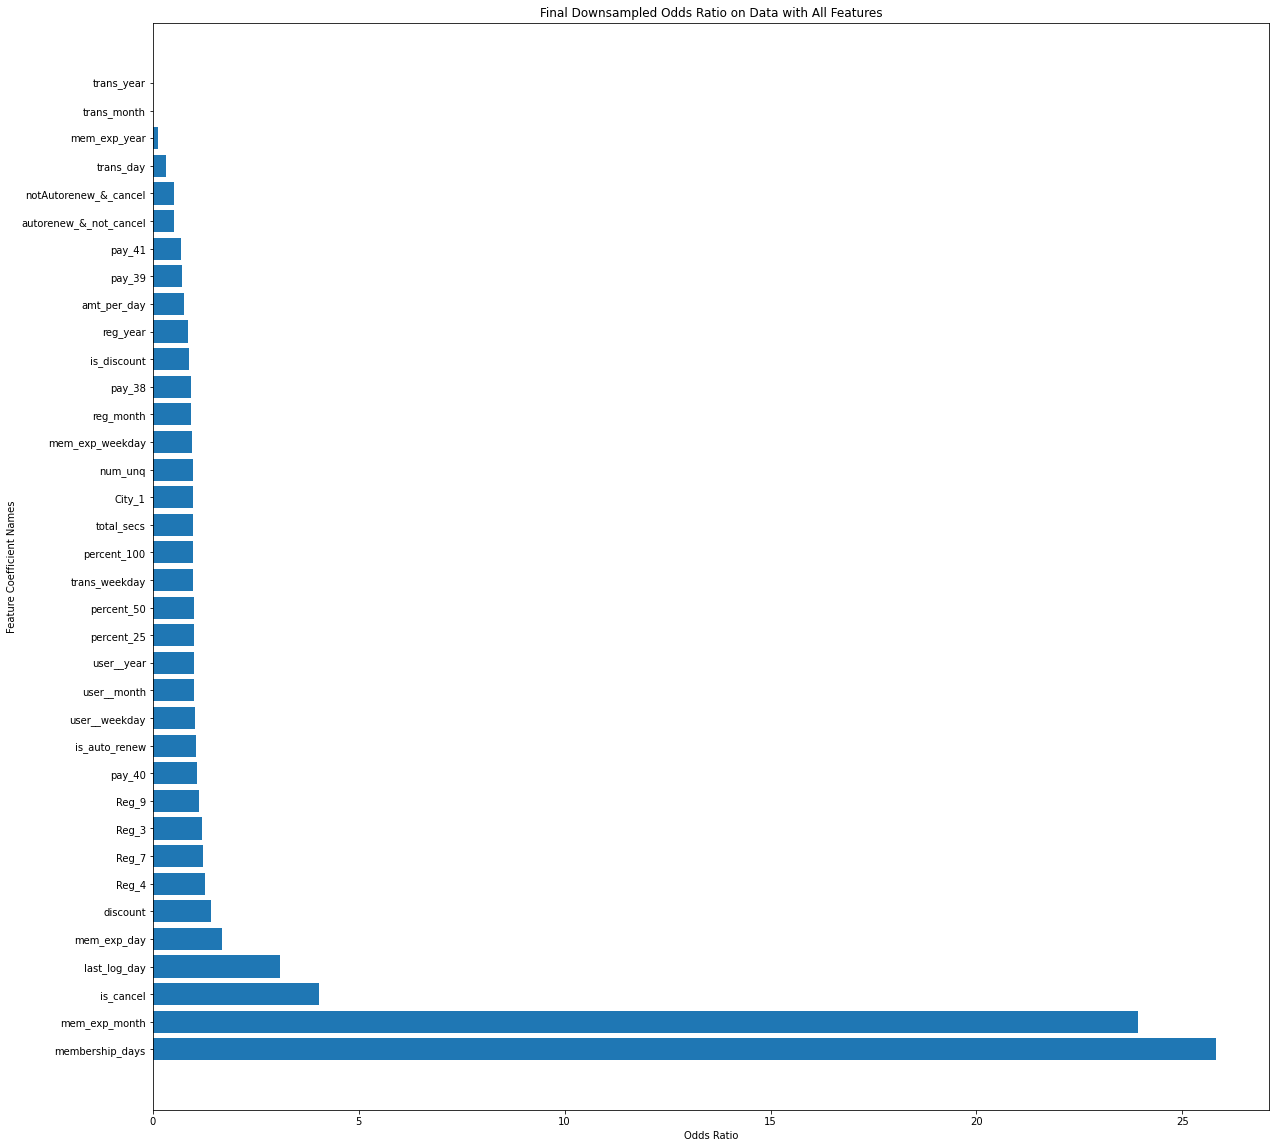

In [92]:
plt.figure(figsize=(20,20))
plt.barh(down_odds_df['Features'],down_odds_df['Odds Ratio'])
plt.title('Final Downsampled Odds Ratio on Data with All Features')
plt.ylabel('Feature Coefficient Names')
plt.xlabel('Odds Ratio')
plt.show()

### Recommendations

**Driving Churn Odds**
- The duration of a membership drives up the churn odds by a factor of 26. We can also see that this is reflected in the coefficients plot (churn prediction is most influenced by memership duration)

- The membership expiration month increases the odds by a factor of 24 while the membership expiration day increases the odds by a facotr of 1.6. 

- Discount increases the odds ratio by a factor of 1.4. Further research should be done here to determine an appropriate discount amount such that users are less likely to churn.

- Cancellations increase the odds ratio by a factor of 4.

- The last day that a user logs in to the KKBox music app increases the odds ratio by a factor of 3. 

**Negative Effect in Churn Odds**

- The transaction year, month, and day have the most negative effect in predicting churn.
- Membership expiration year decreases the odds by a factor of 0.1. 

- The combination of autorenewing and not cancelling, as well as not autorenewing and cancelling surprisingly decrease the odds by a factor of 0.6. 

If we can increase the membership duration (the highest driver of churn) then we can reduce the likelihood or odds that a user will churn. The records where the users last logged in to the app to listen to songs would show an indication of decreased user app activity. This behaviour would signal a red flag that the user might cancel soon, so marketing should target advertising specials to these users to retain them. Then, if the user cancels, marketing can offer new membership sign up promotions or plan discounts as we know that discount also impacts churn odds.

---

#### Data with Selected Features: 20% Downsampled Scaled and Optimized Logistic Model Coefficient and Odds Ratio Visuals

In [44]:
sel_down_coef = churn_logit_sel_down_bal_20_C.coef_
sel_down_coef[0]

array([ 1.37303377e-01,  1.74427846e-01,  1.40515681e-01, -3.22006478e-01,
        1.81142076e-01,  9.53721298e-01,  2.05656623e-01, -1.07215241e-01,
        8.16586975e+00, -1.47143753e+00, -7.13303897e-02, -5.82918330e-03,
       -5.08001359e-03, -5.16330245e-02, -2.48841878e-02, -2.61548052e+00,
       -1.68255977e-01, -6.06277816e-02,  1.78970401e+00,  2.62464742e-02,
        0.00000000e+00,  0.00000000e+00])

In [41]:
X_sel_train.columns

Index(['Reg_3', 'Reg_4', 'Reg_9', 'pay_39', 'pay_40', 'is_cancel',
       'is_discount', 'amt_per_day', 'membership_days',
       'notAutorenew_&_cancel', 'total_secs', 'percent_25', 'percent_50',
       'reg_month', 'trans_weekday', 'trans_month', 'mem_exp_day',
       'mem_exp_weekday', 'mem_exp_month', 'user__weekday', 'user__month',
       'user__year'],
      dtype='object')

In [43]:
# Put the variable names and their feature coefficients into a data frame
sel_down_coefficients_df = pd.DataFrame({'Variable': X_sel_train.columns,
                               'Coefficients': sel_down_coef[0]})
sel_down_coefficients_df.sort_values(by='Coefficients', ascending=False, inplace=True, ignore_index=True) # Sort Feature Coefficients in descending order

sel_down_coefficients_df

,Variable,Coefficients
0,membership_days,8.165870
1,mem_exp_month,1.789704
2,is_cancel,0.953721
3,is_discount,0.205657
4,pay_40,0.181142
5,Reg_4,0.174428
6,Reg_9,0.140516
7,Reg_3,0.137303
8,user__weekday,0.026246
9,user__month,0.000000


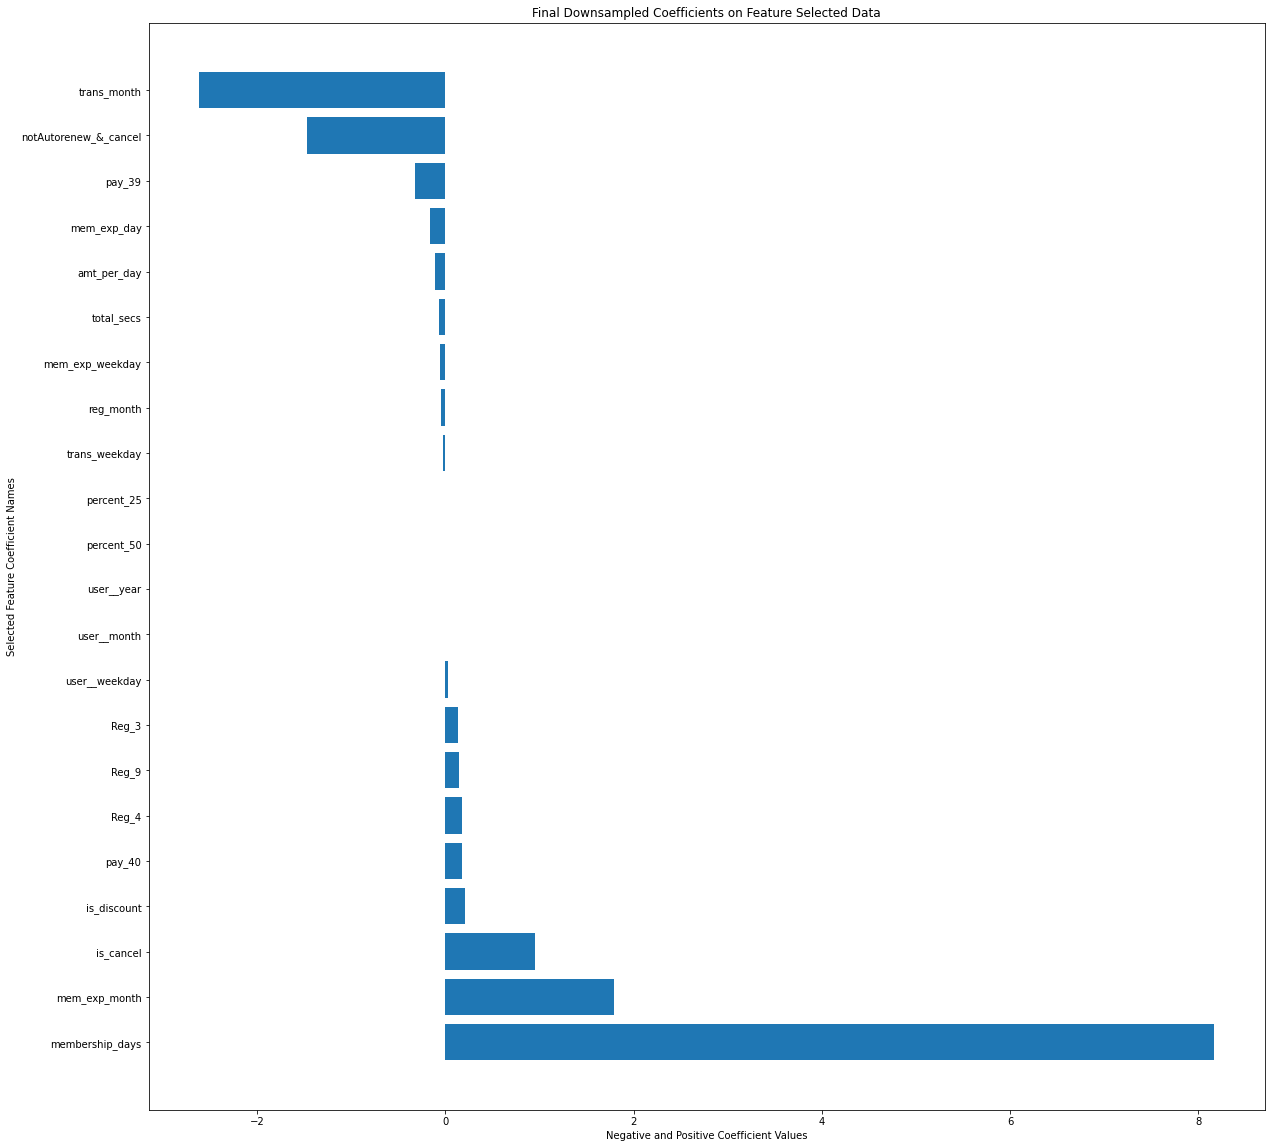

In [45]:
plt.figure(figsize=(20,20))
plt.barh(sel_down_coefficients_df['Variable'],sel_down_coefficients_df['Coefficients'])
plt.title('Final Downsampled Coefficients on Feature Selected Data')
plt.ylabel('Selected Feature Coefficient Names')
plt.xlabel('Negative and Positive Coefficient Values')
plt.show()

In [71]:
final_odds_ratio_sel_down = np.exp(sel_down_coef[0])
final_odds_ratio_sel_down

array([1.14717612e+00, 1.19056484e+00, 1.15086713e+00, 7.24693496e-01,
       1.19858546e+00, 2.59534978e+00, 1.22833135e+00, 8.98332294e-01,
       3.51878046e+03, 2.29595198e-01, 9.31154198e-01, 9.94187773e-01,
       9.94932868e-01, 9.49677311e-01, 9.75422871e-01, 7.31326386e-02,
       8.45137471e-01, 9.41173497e-01, 5.98767993e+00, 1.02659395e+00,
       1.00000000e+00, 1.00000000e+00])

In [72]:
# Put the variable names and their odds ratio into a data frame
sel_down_odds_df = pd.DataFrame({'Variable': X_sel_train.columns,
                           'Odds Ratio': final_odds_ratio_sel_down})
sel_down_odds_df.sort_values(by='Odds Ratio', ascending=False, inplace=True, ignore_index=True) # Sort Feature Coefficients in descending order

sel_down_odds_df

,Variable,Odds Ratio
0,membership_days,3518.780464
1,mem_exp_month,5.987680
2,is_cancel,2.595350
3,is_discount,1.228331
4,pay_40,1.198585
5,Reg_4,1.190565
6,Reg_9,1.150867
7,Reg_3,1.147176
8,user__weekday,1.026594
9,user__month,1.000000


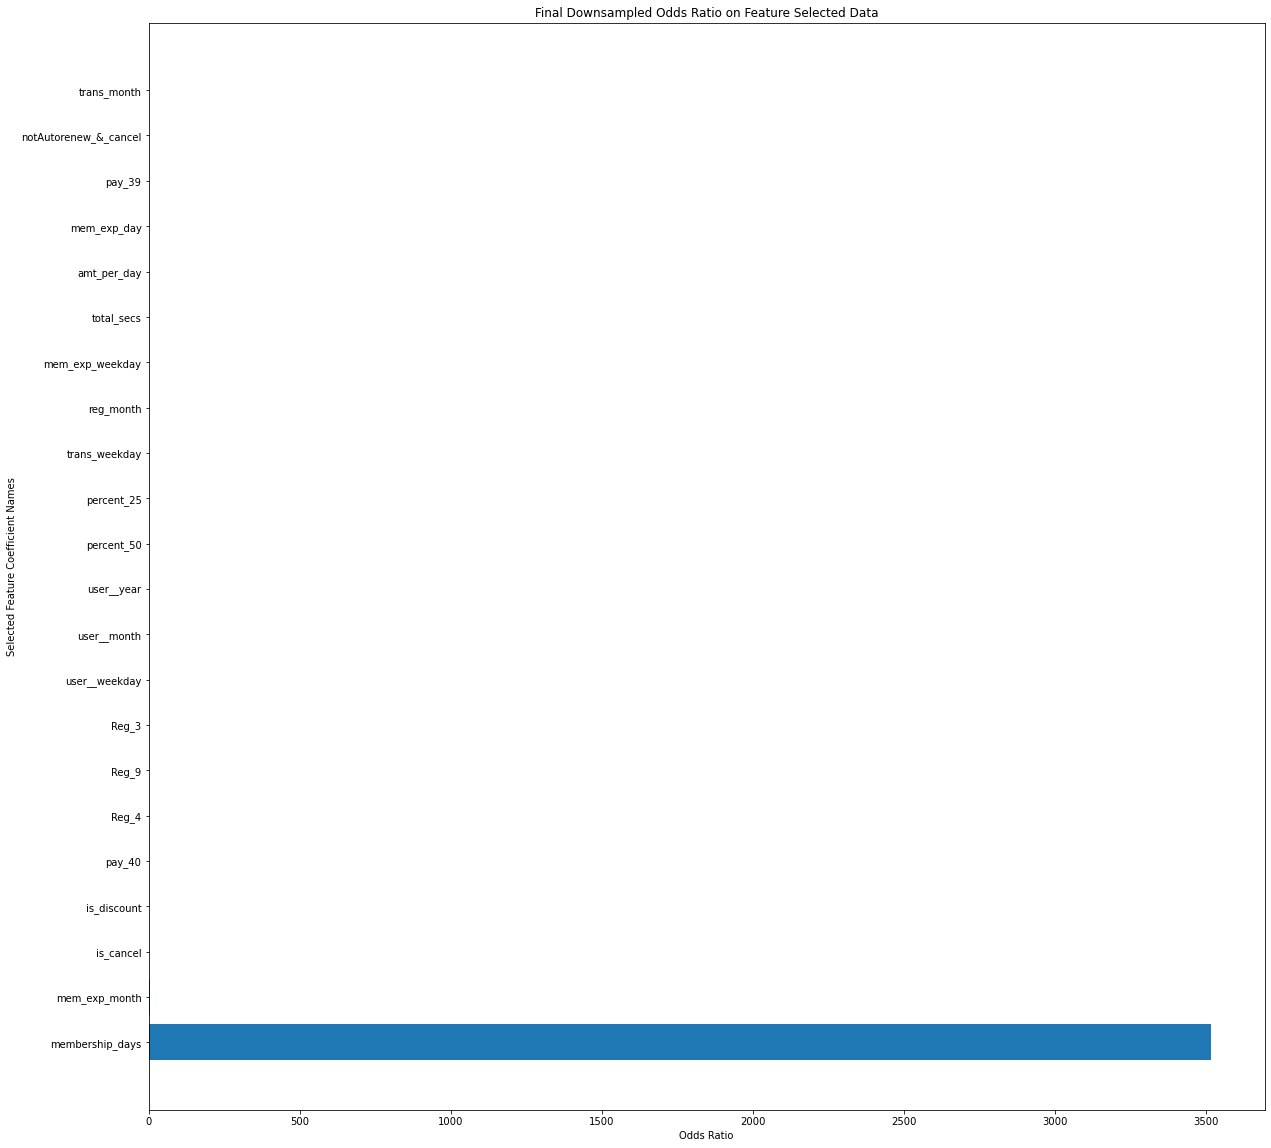

In [73]:
plt.figure(figsize=(20,20))
plt.barh(sel_down_odds_df['Variable'],sel_down_odds_df['Odds Ratio'])
plt.title('Final Downsampled Odds Ratio on Feature Selected Data')
plt.ylabel('Selected Feature Coefficient Names')
plt.xlabel('Odds Ratio')
plt.show()

Similar trends can be observed for our final best logistic model on the data with feature selection. What is interesting is that the membership duration is especially significant and highly correlated with churn. 

### Saving all Models

In [271]:
import joblib

###################
### ALL FEATURES ##
###################

####################
## Initial models ##
####################

#original
joblib.dump(churn_logit, 'churn_logit.pkl')

#upsample with 10% sampling rate
joblib.dump(churn_logit_up_bal, 'churn_logit_up_bal.pkl') 
#upsample with 20% sampling rate
joblib.dump(churn_logit_up_bal_20, 'churn_logit_up_bal_20.pkl') 

#downsample with 10% sampling rate
joblib.dump(churn_logit_down_bal, 'churn_logit_down_bal.pkl')
#downsample with 20% sampling rate
joblib.dump(churn_logit_down_bal_20, 'churn_logit_down_bal_20.pkl')

##############################
###### Pipeline Models #######
##############################

#original fittedgrid pipeline 
joblib.dump(fittedgrid, 'fittedgrid.pkl')

#upsample with 20% sampling rate pipeline model
joblib.dump(up_bal_20_model, 'up_bal_20_model.pkl')

#downsample with 20% sampling rate pipeline model
joblib.dump(down_bal_20_model, 'down_bal_20_model.pkl')

####################
### Final models ###
####################

# base C=10,000
joblib.dump(original_ss_C, 'original_ss_C.pkl')

# upsample with 20% sampling rate C=0.1
joblib.dump(churn_logit_up_bal_20_C, 'churn_logit_up_bal_20_C.pkl')

#downsample with 20% sampling rate C=10,000
joblib.dump(churn_logit_down_bal_20_C, 'churn_logit_down_bal_20_C.pkl')

['churn_logit_down_bal_20_C.pkl']

In [272]:
#########################
### SELECTED FEATURES ###
#########################


##############################
###### Pipeline Models #######
##############################

#base pipeline 
joblib.dump(base_sel_model, 'base_sel_model.pkl')

#upsample with 20% sampling rate pipeline model
joblib.dump(up_sel_bal_20_model, 'up_sel_bal_20_model.pkl')

#downsample with 20% sampling rate pipeline model
joblib.dump(down_sel_bal_20_model, 'down_sel_bal_20_model.pkl')

####################
### Final models ###
####################

# base C=10,000
joblib.dump(base_ss_C, 'base_ss_C.pkl')

# upsample with 20% sampling rate C=0.1
joblib.dump(churn_logit_sel_up_bal_20_C, 'churn_logit_sel_up_bal_20_C.pkl')

#downsample with 20% sampling rate C=10,000
joblib.dump(churn_logit_sel_down_bal_20_C, 'churn_logit_sel_down_bal_20_C.pkl')

['churn_logit_sel_down_bal_20_C.pkl']